In [1]:
import tqdm.auto
import pandas as pd
import numpy as np
import holidays
import func
import math
import pmdarima as pm
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive, SeasonalNaive #Imports the models you will use
from datetime import date
from dateutil.relativedelta import relativedelta
import datetime
from tbats import TBATS
from pmdarima.preprocessing import FourierFeaturizer

#INPUT_PATH = "C:/Users/u00378/Desktop/tcc_est_unb"
INPUT_PATH = "C:/Users/Igor/Desktop/TCC"

df = pd.read_pickle(f'{INPUT_PATH}/dados/tcc_data.pkl')

In [2]:
#########################
### Regiões do brasil ###
#########################
#NORTE ok
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
#NORDESTE ok
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE',\
            'PB', 'SE', 'AL', 'BA']
#CENTRO-OESTE + DF ok
centro_oeste = ['MT', 'MS', 'GO', 'DF']
#SUDESTE ok
sudeste = ['SP', 'RJ', 'ES', 'MG']
#SUL ok
sul = ['PR', 'RS', 'SC']

## Weekday and Holidays

In [3]:
#br_holidays = holidays.country_holidays('BR')  # this is a dict
#mg_holidays = holidays.country_holidays('BR', subdiv='MG')  # this is a dict

#BR_H = list(map(lambda x: br_holidays.get(x), df['data_inversa']))
#MG_H = list(map(lambda x: mg_holidays.get(x), df['data_inversa']))

#WEEKDAYS = list(map(lambda x: x.weekday(), df['data_inversa']))

#BR_H == MG_H

## EDA

In [ ]:
#import matplotlib.pyplot as plt
#Y_hat_df = Y_hat_df.merge(func.sNAIVE(Y_train_df, 28), how='left', on=['unique_id', 'ds'])
#Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

## FORECAST PLOTS

#fig, ax = plt.subplots(1, 1, figsize = (20, 7))
#plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
#plot_df[['y', 'AutoARIMA', 'AutoETS']].plot(ax=ax, linewidth=2)
#ax.set_title('AirPassengers Forecast', fontsize=22)
#ax.set_ylabel('Monthly Passengers', fontsize=20)
#ax.set_xlabel('Timestamp [t]', fontsize=20)
#ax.legend(prop={'size': 15})
#ax.grid()

#plt.show()

## Validação cruzada: avaliação por janela deslizante

- Pela função groe() do pacote forecTheta e função tsCV() do pacote forecast:

(a) H = 28; 4 origens; m = 4 anos;

(b) n1 = 2011-01-02; n2 = 2015-01-02; n3 = 2019-01-03; n4 = 2023-01-04.

CV data: 2007-01-01 to 2023-01-28

train data: 2007-01-01 to 2023-01-31

test data: 2023-02-01 to 2023-02-28

In [36]:
def effect_long_holiday(date, uf):
    import holidays
    hholidays = holidays.country_holidays('BR', subdiv=uf) 
    date_after1 = pd.to_datetime(date) + np.timedelta64(1,'D')
    date_after3 = pd.to_datetime(date) + np.timedelta64(3,'D')
    if (date_after1.day_name() == 'Friday') and (hholidays.get(date_after1)!= None):
        return 1
    elif (date_after3.day_name() == 'Monday') and (hholidays.get(date_after3)!= None):
        return 1
    else:
        return 0
    

def is_long_holiday(date, uf):
    import holidays
    hholidays = holidays.country_holidays('BR', subdiv=uf)
    date = pd.to_datetime(date)
    if (date.day_name() == 'Friday') and (hholidays.get(date)!= None):
        return 1
    else:
        return 0

In [5]:
df['weekday'] = list(map(lambda x: x.weekday(), df['data_inversa']))
df = pd.get_dummies(df, columns=['weekday'], drop_first=True)

isnt_na = lambda x: False if bool(__import__('pandas').isna(x)) else True
filtro1 = np.array(list(map(isnt_na, df['uf'])))
filtro2 = np.array((list(map(isnt_na, df['br']))))

df_tcc = df[(filtro1) & (filtro2)]

In [78]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for uf in np.unique(df_tcc['uf'].dropna()):
    train = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] <= '2023-01-31')].groupby('data_inversa')['id'].agg('nunique').resample('D').sum()
    test = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2023-02-01')&\
                  (df_tcc['data_inversa'] <= '2023-02-28')].groupby('data_inversa')['id'].agg('nunique').resample('D').sum()
    
    index_train = pd.date_range(start = '2007-01-01', end = '2023-01-31', freq = 'd')
    train = train.reindex(index=index_train, fill_value=0)

    index_test = pd.date_range(start = '2023-02-01', end = '2023-02-28', freq = 'd')
    test = test.reindex(index=index_test, fill_value=0)

    holidays_train = list(map(lambda x: 1 if holidays.country_holidays('BR', subdiv=uf).get(x) != None else 0,index_train))
    effect_long_holiday_train = list(map(lambda x: effect_long_holiday(x, uf), index_train))
    long_holiday_train = list(map(lambda x: is_long_holiday(x, uf), index_train))

    holidays_test_test = list(map(lambda x: 1 if holidays.country_holidays('BR', subdiv=uf).get(x) != None else 0, index_test))
    effect_long_holiday_test = list(map(lambda x: effect_long_holiday(x, uf), index_test))
    long_holiday_test = list(map(lambda x: is_long_holiday(x, uf), index_test))

    train_df = pd.concat([train_df, pd.DataFrame({'unique_id': [uf]*len(index_train), 'ds':index_train, 'y':train, 'is_holiday':holidays_train,\
                                                  'effect_long_holiday':effect_long_holiday_train, 'is_long_holiday':long_holiday_train})], axis = 0)
    
    test_df = pd.concat([test_df, pd.DataFrame({'unique_id': [uf]*len(index_test), 'ds':index_test, 'y':test, 'is_holiday':holidays_test_test,\
                                                  'effect_long_holiday':effect_long_holiday_test, 'is_long_holiday':long_holiday_test})], axis = 0)

train_df.to_excel('train_df.xlsx')
test_df.to_excel('test_df.xlsx')

In [292]:
train_df = pd.read_excel('train_df.xlsx')
test_df = pd.read_excel('test_df.xlsx')
train_df = train_df.iloc[:,1:]
test_df = test_df.iloc[:,1:]

cols = list(map(lambda x: f'F{x}', range(1, 29)))
submission_file = pd.DataFrame(np.zeros(shape= (208,28)), index = np.unique(df_tcc['br']), columns = cols)
submission_file.index.names = ['br']

cv_df = pd.DataFrame(np.zeros(shape= (27,5)), index = np.unique(df_tcc['uf']), columns = ['TBATS', 'DHR', 'RAE', 'AutoARIMA', 'sNAIVE'])
cv_df.index.names = ['uf']

for uf in np.unique(df_tcc['uf'].dropna()):
    mae_tbats = []
    mae_dhr = []
    mae_rae = []
    mae_arima = []
    mae_snaive = []
    final_date = pd.to_datetime('2007-01-01')
    for i in range(1, 5):
        train_df_c = train_df.copy()
        final_date = final_date +  np.timedelta64(4,'Y')

        test_df_c = train_df_c[(train_df_c['unique_id'] == uf) & (train_df_c['ds'] >= str((final_date + np.timedelta64(1,'D')).date()))\
                              & (train_df_c['ds'] <= str((final_date + np.timedelta64(28,'D')).date()))]
        train_df_c = train_df_c[(train_df_c['unique_id'] == uf) & (train_df_c['ds'] <= str(final_date.date()))]

        horizon = len(test_df_c) # Predict the lenght of the test df

        sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==uf])
        Y_hat_df1 = sf1.predict(h=horizon, X_df=test_df_c[test_df_c['unique_id']==uf][['unique_id', 'ds', 'is_holiday', 'effect_long_holiday', 'is_long_holiday']])

        sf2 = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
        sf2.fit(df=train_df_c[train_df_c['unique_id']==uf][['unique_id', 'ds', 'y']])
        Y_hat_df2 = sf2.predict(h=horizon)

        sf3 = StatsForecast(models=[AutoARIMA(season_length=7, seasonal = False)], freq='D', n_jobs=-1)
        trans = FourierFeaturizer(7, 2)
        y_prime, x_f = trans.fit_transform(train_df_c[train_df_c['unique_id']==uf]['y'].values)
        sf3.fit(df=pd.concat([train_df_c[train_df_c['unique_id']==uf].reset_index(drop=True), x_f], axis = 1))
        Y_hat_df3 = sf3.predict(h=horizon, X_df=pd.concat([test_df[test_df['unique_id']==uf].reset_index(drop=True), pd.DataFrame(x_f[-28:])\
                                                        .reset_index(drop=True)], axis = 1).drop('y', axis = 1))
            
        #result_auto_arima = pm.auto_arima(train.values, d = 1, start_p=0, start_q=0, max_p=3, max_q=3,\
        #                          seasonal = True, m = 7, D=1, start_P=0, start_Q=0, max_P=1, max_Q=1,\
        #                            information_criterion='aic', error_action='ignore', stepwise=True)

        result_auto_arima = pm.auto_arima(train_df_c['y'], seasonal = True, m = 7, start_p=0, start_q=0, max_p=1, max_q=1,\
                                          start_P=0, start_Q=0, max_P=1, max_Q=1)
        auto_arima_forecast= result_auto_arima.predict(28)

        result_tbats = TBATS(seasonal_periods=[7, 365.25/12, 365.25], n_jobs=1, \
                              use_box_cox= False, use_arma_errors=False)
        
        fitted_tbats = result_tbats.fit(train_df_c['y'])
        tbats_forecast_valid = fitted_tbats.forecast(steps = 28)
        
        y_true = test_df_c['y'].values
        tbats_preds = tbats_forecast_valid
        dhr_preds = Y_hat_df3['AutoARIMA'].values
        rae_preds = Y_hat_df1['AutoARIMA'].values
        arima_preds = auto_arima_forecast
        snaive_preds = Y_hat_df2['SeasonalNaive'].values

        mae_tbats.append(func.mae(tbats_preds, y_true))
        mae_dhr.append(func.mae(dhr_preds, y_true))
        mae_rae.append(func.mae(rae_preds, y_true))
        mae_arima.append(func.mae(arima_preds, y_true))
        mae_snaive.append(func.mae(snaive_preds, y_true))

    cv = {'TBATS': np.mean(mae_tbats), 'DHR':np.mean(mae_dhr), 'RAE': np.mean(mae_rae), 'AutoARIMA': np.mean(mae_arima), 'sNAIVE': np.mean(mae_snaive)}
    cv_df.loc[uf] = list(cv.values())

    best_model = min(cv, key=cv.get)

    train_df_c = train_df.copy()
    test_df_c = test_df.copy()

    train_df_c = train_df_c[(train_df_c['unique_id'] == uf) & (train_df_c['ds'] <= '2023-01-31')]
    test_df_c = test_df_c[(test_df_c['unique_id'] == uf) & (test_df_c['ds'] >= '2023-02-01')\
                              & (test_df_c['ds'] <= '2023-02-28')]
    if best_model == 'TBATS':
        result_tbats = TBATS(seasonal_periods=[7, 365.25/12, 365.25], n_jobs=1, \
                              use_box_cox= False, use_arma_errors=False) 
        fitted_tbats = result_tbats.fit(train_df_c[train_df_c['unique_id']==uf]['y'].values)
        tbats_forecast = fitted_tbats.forecast(steps = 28)

        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2023-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/28)/(sum(rot['nunique'])/28) #Top-down approaches: Proportions of the historical averages

        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (tbats_forecast*rot.loc[br]['proportion'])

    elif best_model == 'DHR':
        sf1 = StatsForecast(models=[AutoARIMA(season_length=7, seasonal = False)], freq='D', n_jobs=-1)
        trans = FourierFeaturizer(7, 2)
        y_prime, x_f = trans.fit_transform(train_df_c[train_df_c['unique_id']==uf]['y'].values)
        sf1.fit(df=pd.concat([train_df_c[train_df_c['unique_id']==uf].reset_index(drop=True), x_f], axis = 1))
        Y_hat_df1 = sf1.predict(h=28, X_df=pd.concat([test_df[test_df['unique_id']==uf].reset_index(drop=True), pd.DataFrame(x_f[-28:])\
                                                        .reset_index(drop=True)], axis = 1).drop('y', axis = 1))
        
        dhr_forecast = Y_hat_df1['AutoARIMA'].values
        
        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2023-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/28)/(sum(rot['nunique'])/28) #Top-down approaches: Proportions of the historical averages

        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (dhr_forecast*rot.loc[br]['proportion'])


    elif best_model == 'RAE':
        sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==uf])
        Y_hat_df1 = sf1.predict(h=28, X_df=test_df_c[test_df_c['unique_id']==uf][['unique_id', 'ds', 'is_holiday', 'effect_long_holiday', 'is_long_holiday']])
        rae_forecast = Y_hat_df1['AutoARIMA'].values

        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2023-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/28)/(sum(rot['nunique'])/28) #Top-down approaches: Proportions of the historical averages
        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (rae_forecast*rot.loc[br]['proportion'])
            
    elif best_model == 'AutoARIMA':
        sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==uf][['unique_id', 'ds', 'y']])
        Y_hat_df1 = sf1.predict(h=28)
        autoarima_forecast = Y_hat_df1['AutoARIMA'].values

        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2023-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/28)/(sum(rot['nunique'])/28) #Top-down approaches: Proportions of the historical averages
        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (autoarima_forecast*rot.loc[br]['proportion'])

    elif best_model == 'sNAIVE':
        sf1 = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
        sf1.fit(df=train_df_c[train_df_c['unique_id']==uf][['unique_id', 'ds', 'y']])
        Y_hat_df1 = sf1.predict(h=28)
        snaive_forecast = Y_hat_df1['SeasonalNaive'].values

        rot = df_tcc[(df_tcc['uf'] == uf) & (df_tcc['data_inversa'] >= '2023-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby(['br'])['id']\
            .agg(['nunique'])
        rot['proportion'] = (rot['nunique']/28)/(sum(rot['nunique'])/28) #Top-down approaches: Proportions of the historical averages
        for br in rot.index.values:
            submission_file.loc[br] = submission_file.loc[br] +  (snaive_forecast*rot.loc[br]['proportion'])


submission_file.round(0).to_excel('submission.xlsx')
cv_df.to_excel('cv_summary.xlsx')

In [395]:
submission_file[np.sum(submission_file.round(0), axis = 1).values!=0].round(0).to_excel('filtered submission.xlsx')

submission_file[np.sum(submission_file.round(0), axis = 1).values!=0].round(0)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
br,,,,,,,,,,,,,,,,,,,,,
10,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
101,27.0,31.0,36.0,37.0,35.0,32.0,28.0,28.0,31.0,36.0,...,34.0,31.0,29.0,29.0,31.0,36.0,37.0,34.0,31.0,28.0
104,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
110,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
116,24.0,26.0,29.0,29.0,28.0,26.0,23.0,24.0,26.0,29.0,...,28.0,26.0,25.0,26.0,26.0,29.0,30.0,28.0,26.0,24.0
135,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
153,5.0,6.0,7.0,8.0,8.0,6.0,5.0,5.0,6.0,7.0,...,7.0,6.0,5.0,6.0,6.0,7.0,8.0,7.0,6.0,5.0
158,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
163,6.0,6.0,7.0,8.0,7.0,6.0,5.0,6.0,6.0,7.0,...,7.0,5.0,5.0,5.0,5.0,6.0,7.0,6.0,5.0,5.0


In [301]:
cv_df

,TBATS,DHR,RAE,AutoARIMA,sNAIVE
uf,,,,,
AC,0.722910,0.766908,0.753662,0.715928,0.919643
AL,1.468320,1.557174,1.560410,1.551341,1.678571
AM,0.431021,0.486350,0.506922,0.690807,0.580357
AP,0.573140,0.555080,0.601725,0.618204,0.651786
BA,4.128657,4.070326,3.973081,4.015497,5.062500
CE,2.565525,2.577310,2.524258,2.529742,3.767857
DF,1.400072,1.403529,1.379113,1.392283,1.687500
ES,4.070340,3.770581,3.935404,3.742955,5.089286
GO,3.783681,3.956640,4.043865,4.024660,4.589286


In [448]:
forecast = pd.DataFrame({'Forecast_fev': np.sum(submission_file.round(0), axis = 1).values, 'index':np.sum(submission_file.round(0), axis = 1).index}).set_index('index')\
    .sort_values('Forecast_fev', ascending=False)

true =pd.DataFrame({'True_fev':df_tcc[(df_tcc['data_inversa'] >= '2023-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby('br')['id'].count().values,\
                    'index':df_tcc[(df_tcc['data_inversa'] >= '2023-01-01')& (df_tcc['data_inversa'] <= '2023-01-31')].groupby('br')['id'].count().index})\
                        .set_index('index').sort_values('True_fev', ascending=False)


In [449]:
forecast.iloc[0:7,:]

,Forecast_fev
index,
101,904.0
116,746.0
40,245.0
381,237.0
153,177.0
163,171.0
364,167.0


In [450]:
true.iloc[0:7,:]

,True_fev
index,
101,993
116,796
40,267
381,253
153,192
364,167
163,167


In [451]:
final_result = pd.DataFrame()
for i in true.iloc[0:7,:].index.values:
    y = df_tcc[(df_tcc['br'] == i) & (df_tcc['data_inversa'] >= '2023-02-01')& (df_tcc['data_inversa'] <= '2023-02-28')]\
        .groupby('data_inversa')['id'].agg('nunique').resample('D').sum()
    index_y= pd.date_range(start = '2023-02-01', end = '2023-02-28', freq = 'd')
    y_true = y.reindex(index=index_y, fill_value=0)

    forecast = submission_file.loc[i].round(0).values
    unique_id = [i]*len(index_y)
    ds = index_y.values
    
    a = pd.DataFrame({'unique_id':unique_id, 'ds':ds, 'n_acidentes':y_true, 'forecast':forecast})

    final_result = pd.concat([final_result, a], axis = 0)

In [452]:
StatsForecast.plot(final_result)

In [453]:
#(df_tcc['br'].isin(submission_file[submission_file!=0].dropna().index.values))


final_result = pd.DataFrame({'index': pd.date_range(start = '2023-02-01', end = '2023-02-28', freq = 'd'),\
                             'n_acidentes':df_tcc[(df_tcc['data_inversa'] >= '2023-02-01')& (df_tcc['data_inversa'] <= '2023-02-28')]\
                                .groupby('data_inversa')['id'].agg('nunique').resample('D').sum().values,\
                                    'forecast':submission_file.sum().round(0).values}).set_index('index')

<AxesSubplot:xlabel='index'>

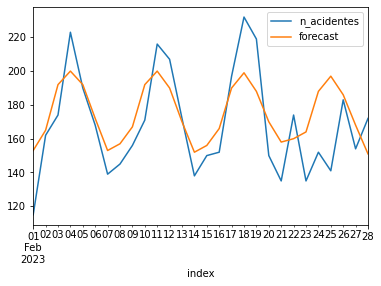

In [455]:
final_result.plot()

In [489]:
np.mean(abs(final_result['n_acidentes']-final_result['forecast']))

17.928571428571427

In [ ]:
y = df_tcc[(df_tcc['data_inversa']<='2023-01-31')].groupby('data_inversa')['id'].count()
index = pd.date_range(start = '2007-01-01', end = '2023-01-31', freq = 'd')
y = y.reindex(index=index, fill_value=0)

y_test = df_tcc[(df_tcc['data_inversa']>='2023-02-01') & ((df_tcc['data_inversa']<='2023-02-28'))].groupby('data_inversa')['id'].count()
index_test = pd.date_range(start = '2023-02-01', end = '2023-02-28', freq = 'd')
y_test = y_test.reindex(index=index_test, fill_value=0)

result_tbats = TBATS(seasonal_periods=[7, 365.25/12, 365.25], n_jobs=1, \
                              use_box_cox= False, use_arma_errors=False) 
fitted_tbats = result_tbats.fit(y.values)
tbats_forecast = fitted_tbats.forecast(steps = 28)

pd.DataFrame({'index':index_test, 'y_test':y_test,'forecast':tbats_forecast}).set_index('index').plot()

<AxesSubplot:xlabel='index'>

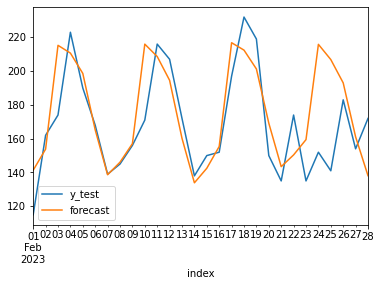

In [483]:
pd.DataFrame({'index':index_test, 'y_test':y_test,'forecast':tbats_forecast}).set_index('index').plot()

In [485]:
np.mean(abs(tbats_forecast-y_test))

18.108437824026208

<AxesSubplot:xlabel='ds'>

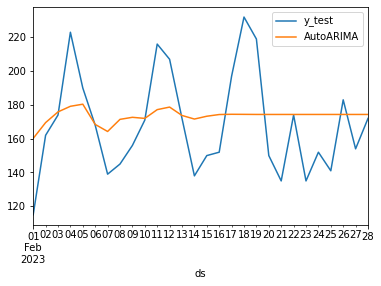

In [479]:
y = df_tcc[(df_tcc['data_inversa']<='2023-01-31')].groupby('data_inversa')['id'].count()
index = pd.date_range(start = '2007-01-01', end = '2023-01-31', freq = 'd')
y = y.reindex(index=index, fill_value=0)

df = pd.DataFrame({'unique_id':'Brasil', 'ds': index, 'y':y.values})

y_test = df_tcc[(df_tcc['data_inversa']>='2023-02-01') & ((df_tcc['data_inversa']<='2023-02-28'))].groupby('data_inversa')['id'].count()
index_test = pd.date_range(start = '2023-02-01', end = '2023-02-28', freq = 'd')
y_test = y_test.reindex(index=index_test, fill_value=0)

sf1 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
sf1.fit(df=df)
Y_hat_df1 = sf1.predict(h=28)
Y_hat_df1['y_test'] = y_test.values

Y_hat_df1.set_index('ds')[['y_test', 'AutoARIMA']].plot()

In [ ]:
cols = list(map(lambda x: f'A{x}', range(1, 29)))
actual_file = pd.DataFrame(np.zeros(shape= (208,28)), index = np.unique(df_tcc['br']), columns = cols)
actual_file.index.names = ['br']